In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sys

sys.path.append(os.path.abspath("../"))
from dataset import DS_NAMES
from dataset import DS_DIMENSIONS
from utilities.figure_tools import get_latest_results_directory, make_fig_directory, load_results

ntrees = 300
results_path = "../results/turing/vary_sigma_{:03d}t.csv".format(ntrees)
output_dir = "./vary_sigma_{:03d}t/".format(ntrees)
export_figures = True

if export_figures and not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [3]:
all_results = pd.read_csv(results_path).groupby(["explainer", "dataset", "facet_sd"]).mean().reset_index()
# print("explainers:", list(all_results["explainer"].unique()))
# print("datasets", list(all_results["dataset"].unique()))
all_results.head()

,explainer,dataset,facet_sd,n_trees,max_depth,iteration,accuracy,precision,recall,f1,per_valid,avg_dist,avg_length,prep_time,explain_time,sample_time,n_explain
0,FACETIndex,cancer,0.001,200.0,NaN,4.5,0.954386,0.9508,0.920925,0.934957,1.0,0.465673,20.70,98.207707,1.359516,0.067976,20.0
1,FACETIndex,cancer,0.005,200.0,NaN,4.5,0.954386,0.9508,0.920925,0.934957,1.0,0.449526,19.83,101.767179,2.955360,0.147768,20.0
2,FACETIndex,cancer,0.010,200.0,NaN,4.5,0.954386,0.9508,0.920925,0.934957,1.0,0.440959,19.59,103.147570,3.675335,0.183767,20.0
3,FACETIndex,cancer,0.050,200.0,NaN,4.5,0.954386,0.9508,0.920925,0.934957,1.0,0.403995,17.64,99.928980,4.843199,0.242160,20.0
4,FACETIndex,cancer,0.100,200.0,NaN,4.5,0.954386,0.9508,0.920925,0.934957,1.0,0.396914,16.50,94.588356,5.402988,0.270149,20.0


In [4]:
all_results["facet_sd"].unique()

array([0.001, 0.005, 0.01 , 0.05 , 0.1  , 0.15 , 0.2  , 0.25 ])

In [5]:
idx = all_results.groupby(["explainer", "dataset"])["avg_dist"].idxmin()
all_results.loc[idx, ["dataset", "facet_sd", "per_valid", "prep_time", "explain_time", "avg_dist", "sample_time"]]

,dataset,facet_sd,per_valid,prep_time,explain_time,avg_dist,sample_time
4,cancer,0.100,1.0,94.588356,5.402988,0.396914,0.270149
11,glass,0.050,1.0,72.315596,0.753223,0.119089,0.037661
16,magic,0.001,1.0,101.078347,0.737526,0.126139,0.036876
26,spambase,0.010,1.0,101.624404,1.386676,0.110743,0.069334
35,vertebral,0.050,1.0,79.943576,0.435091,0.101382,0.021755


In [6]:
df = all_results[["dataset", "facet_sd", "avg_dist"]]
df = df.set_index(["dataset", "facet_sd"])
df = df.stack()
df = df.unstack(level=1)
df.head(20)

,facet_sd,0.001,0.005,0.010,0.050,0.100,0.150,0.200,0.250
dataset,,,,,,,,,
cancer,avg_dist,0.465673,0.449526,0.440959,0.403995,0.396914,0.404418,0.426397,0.440894
glass,avg_dist,0.201066,0.186090,0.168607,0.119089,0.123929,0.133269,0.139360,0.149539
magic,avg_dist,0.126139,0.128692,0.128306,0.134490,0.158375,0.181649,0.199623,0.219454
spambase,avg_dist,0.185637,0.137876,0.110743,0.130042,0.159809,0.182861,0.201351,0.213530
vertebral,avg_dist,0.160082,0.142873,0.130882,0.101382,0.102894,0.109567,0.115590,0.121054


In [7]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors
ds_colors = {
    "cancer": colors[0],
    "glass": colors[1],
    "magic": colors[2],
    "spambase": colors[3],
    "vertebral": colors[4]
}
ds_markers = {
    "cancer": "^",
    "glass": "o",
    "magic": "v",
    "spambase": "s",
    "vertebral": "D"
}
marker_size = 8
line_width = 2
marker_sizes = {
    "cancer": marker_size,
    "glass": marker_size,
    "magic": marker_size,
    "spambase": marker_size,
    "vertebral": marker_size
}

In [8]:
def render_plot(xfeature, yfeature, xlabel, ylabel, title, save_name=None, xrange=None, yrange=None, xlog=False, ylog=False, lloc=None, loc="best", lhorz=False):

    fig = plt.figure(figsize=[6.4, 4.8], frameon=True)
    ax = fig.add_subplot(1, 1, 1)
    for ds in all_results["dataset"].unique():
        is_ds = all_results["dataset"] == ds
        for expl in all_results["explainer"].unique():
            is_expl = all_results["explainer"] == expl
            matching_rows = is_ds & is_expl
            ax.plot(all_results[matching_rows][xfeature], all_results[matching_rows][yfeature], label=ds, lw=line_width, marker=ds_markers[ds], ms=marker_sizes[ds], color=ds_colors[ds])

        # title and axis labels
        if title is not None:
            plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        # legend
        if lhorz:
            plt.legend(loc=loc, ncol=len(all_results["dataset"].unique()), bbox_to_anchor=(0, 1.09, 1, 0), handletextpad=0.5, columnspacing=1, handlelength=1.5)
        else:
            plt.legend(loc=loc)
        # x and y ranges
        if xrange is not None:
            plt.xlim(xrange)
        if yrange is not None:
            plt.ylim(yrange)
        
        # x and y scales
        if ylog:
            plt.yscale('log')
        if xlog:
            plt.xscale('log')
        plt.subplots_adjust(top=1.0)

        if export_figures and save_name is not None:
            plt.savefig(output_dir + save_name, bbox_inches="tight")

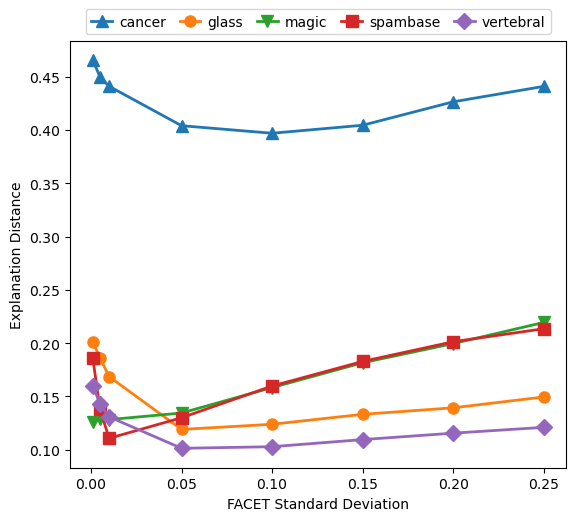

In [9]:
render_plot(xfeature="facet_sd", yfeature="avg_dist", xlabel="FACET Standard Deviation", ylabel="Explanation Distance", title=None, save_name="dist_vs_sigma.png", loc="upper center", lhorz=True)

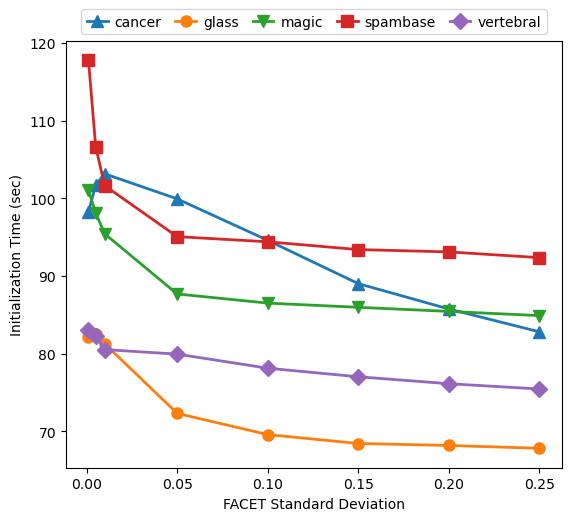

In [10]:
render_plot(xfeature="facet_sd", yfeature="prep_time", xlabel="FACET Standard Deviation", ylabel="Initialization Time (sec)", title=None, save_name="prep_vs_sigma.png", loc="upper center", lhorz=True)

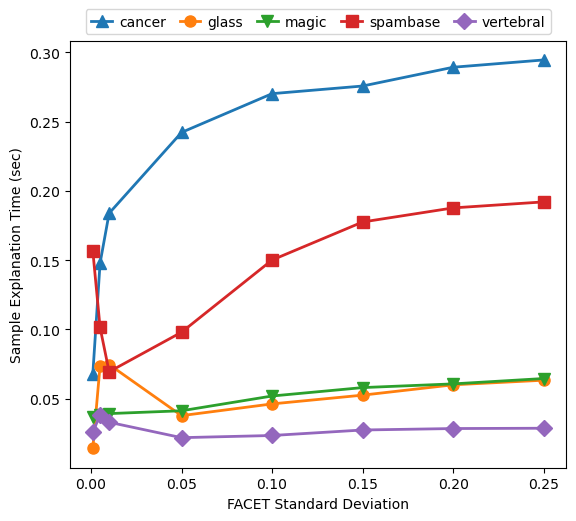

In [11]:
render_plot(xfeature="facet_sd", yfeature="sample_time", xlabel="FACET Standard Deviation", ylabel="Sample Explanation Time (sec)", title=None, save_name="sampletime_vs_sigma.png", loc="upper center", lhorz=True)